In [1]:
## 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import re
import os
import yaml
import joblib
from typing import List, Dict, Tuple
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import xgboost as xgb

print("✅ 라이브러리 임포트 완료")

C:\Users\tjdwl\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



✅ 라이브러리 임포트 완료


In [2]:
## 설정 파일 생성
config = {
    'model': {
        'sbert_model': 'snunlp/KR-SBERT-V40K-klueNLI-augSTS',
        'dimensionality_reduction': 'PCA',
        'reduced_dim': 128,
        'xgboost_params': {
            'objective': 'reg:squarederror',
            'n_estimators': 100,
            'max_depth': 5,
            'learning_rate': 0.1,
            'random_state': 42
        }
    },
    'recommendation': {
        'similarity_weight': 0.6,
        'tag_weight': 0.4
    }
}

# 설정 저장
os.makedirs('config', exist_ok=True)
with open('config/config.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(config, f, allow_unicode=True)

print("✅ 설정 파일 생성 완료: config/config.yaml")

✅ 설정 파일 생성 완료: config/config.yaml


In [3]:
## 데이터 전처리 클래스

class DataPreprocessor:
    """데이터 전처리 클래스"""
    
    def __init__(self):
        self.season_encoder = None
        self.nature_encoder = MultiLabelBinarizer()
        self.vibe_encoder = MultiLabelBinarizer()
        self.target_encoder = MultiLabelBinarizer()
    
    def parse_multi_label_string(self, text: str) -> List[str]:
        """쉼표로 구분된 문자열을 리스트로 변환"""
        if pd.isna(text) or text == '':
            return []
        items = [item.strip() for item in str(text).split(',')]
        return [item for item in items if item]
    
    def _augment_single_row(self, row) -> str:
        """✨ 단일 행의 설명 텍스트 증강"""
        original = str(row['short_description'])
        
        # 계절 정보
        season_text = f"이곳은 {row['season']}에 특히 아름답습니다."
        
        # 자연환경 정보
        if row['nature_list']:
            nature_text = f"{', '.join(row['nature_list'])} 경관을 즐길 수 있습니다."
        else:
            nature_text = ""
        
        # 분위기 정보
        if row['vibe_list']:
            vibe_text = f"{', '.join(row['vibe_list'])} 분위기로 좋습니다."
        else:
            vibe_text = ""
        
        # 대상 정보
        if row['target_list']:
            target_text = f"{', '.join(row['target_list'])}에게 추천합니다."
        else:
            target_text = ""
        
        # 모든 정보 결합
        augmented = f"{original} {season_text} {nature_text} {vibe_text} {target_text}"
        return augmented.strip()
    
    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """데이터 전처리 메인 함수"""
        processed_df = df.copy()
        
        # 필수 컬럼 확인
        required_cols = ['name', 'season', 'nature', 'vibe', 'target', 'short_description']
        missing_cols = [col for col in required_cols if col not in processed_df.columns]
        if missing_cols:
            raise ValueError(f"필수 컬럼이 없습니다: {missing_cols}")
        
        # 결측치 처리
        processed_df['short_description'] = processed_df['short_description'].fillna('')
        processed_df['season'] = processed_df['season'].fillna('사계절')
        processed_df['nature'] = processed_df['nature'].fillna('')
        processed_df['vibe'] = processed_df['vibe'].fillna('')
        processed_df['target'] = processed_df['target'].fillna('')
        
        # 다중 레이블 파싱
        processed_df['nature_list'] = processed_df['nature'].apply(self.parse_multi_label_string)
        processed_df['vibe_list'] = processed_df['vibe'].apply(self.parse_multi_label_string)
        processed_df['target_list'] = processed_df['target'].apply(self.parse_multi_label_string)
        
        # 텍스트 정규화
        processed_df['short_description'] = processed_df['short_description'].apply(
            lambda x: re.sub(r'[^\w\s]', '', str(x)) if pd.notna(x) else ''
        )
        
        # ✨ 데이터 증강
        print("📝 데이터 증강 중...")
        processed_df['enhanced_description'] = processed_df.apply(
            self._augment_single_row, axis=1
        )
        print(f"✅ 데이터 증강 완료! ({len(processed_df)}개)")
        
        return processed_df
    
    def fit_encoders(self, df: pd.DataFrame):
        """인코더들을 학습 데이터에 맞춤"""
        self.season_categories = sorted(df['season'].unique())
        self.nature_encoder.fit(df['nature_list'])
        self.vibe_encoder.fit(df['vibe_list'])
        self.target_encoder.fit(df['target_list'])
        
        print(f"인코더 학습 완료")
        print(f"   - 계절 카테고리: {self.season_categories}")
        print(f"   - 자연환경: {len(self.nature_encoder.classes_)}개")
        print(f"   - 분위기: {len(self.vibe_encoder.classes_)}개")
        print(f"   - 대상: {len(self.target_encoder.classes_)}개")
    
    def encode_labels(self, df: pd.DataFrame) -> Dict[str, np.ndarray]:
        """레이블들을 인코딩"""
        # 계절 인코딩
        season_encoded = np.zeros((len(df), len(self.season_categories)))
        for i, season in enumerate(df['season']):
            if season in self.season_categories:
                season_idx = self.season_categories.index(season)
                season_encoded[i, season_idx] = 1
        
        # 다중 레이블 인코딩
        nature_encoded = self.nature_encoder.transform(df['nature_list'])
        vibe_encoded = self.vibe_encoder.transform(df['vibe_list'])
        target_encoded = self.target_encoder.transform(df['target_list'])
        
        return {
            'season': season_encoded,
            'nature': nature_encoded,
            'vibe': vibe_encoded,
            'target': target_encoded
        }
    
    def save_encoders(self, base_path: str):
        """인코더들을 저장"""
        joblib.dump(self.season_categories, f"{base_path}/season_encoder.joblib")
        joblib.dump(self.nature_encoder, f"{base_path}/nature_encoder.joblib")
        joblib.dump(self.vibe_encoder, f"{base_path}/vibe_encoder.joblib")
        joblib.dump(self.target_encoder, f"{base_path}/target_encoder.joblib")
        print(f"인코더 저장 완료: {base_path}")
    
    def load_encoders(self, base_path: str):
        """인코더 로드"""
        self.season_categories = joblib.load(f"{base_path}/season_encoder.joblib")
        self.nature_encoder = joblib.load(f"{base_path}/nature_encoder.joblib")
        self.vibe_encoder = joblib.load(f"{base_path}/vibe_encoder.joblib")
        self.target_encoder = joblib.load(f"{base_path}/target_encoder.joblib")
        print(f"인코더 로드 완료: {base_path}")

print("✅ DataPreprocessor 클래스 정의 완료")

✅ DataPreprocessor 클래스 정의 완료


In [4]:
## 임베딩 생성 클래스

class EmbeddingGenerator:
    """SBERT 임베딩 생성 클래스"""
    
    def __init__(self, model_name: str = 'snunlp/KR-SBERT-V40K-klueNLI-augSTS'):
        self.model_name = model_name
        self.model = None
        self.dimension_reducer = None
        self.reduced_dim = None
    
    def load_model(self):
        """SBERT 모델 로드"""
        print(f"SBERT 모델 로드 중: {self.model_name}")
        self.model = SentenceTransformer(self.model_name)
        print("SBERT 모델 로드 완료")
    
    def generate_embeddings(self, texts: List[str], use_enhanced: bool = True) -> np.ndarray:
        """✨ 임베딩 생성 (개선 버전)"""
        if self.model is None:
            self.load_model()
        
        print(f"임베딩 생성 중... (총 {len(texts)}개)")
        
        if use_enhanced:
            # ✨ 정규화 + 최적화된 배치 처리
            embeddings = self.model.encode(
                texts,
                convert_to_numpy=True,
                normalize_embeddings=True,  # L2 정규화
                show_progress_bar=True,
                batch_size=16
            )
        else:
            # 기존 방식
            batch_size = 32
            embeddings = []
            for i in tqdm(range(0, len(texts), batch_size)):
                batch_texts = texts[i:i+batch_size]
                batch_embeddings = self.model.encode(batch_texts, convert_to_numpy=True)
                embeddings.append(batch_embeddings)
            embeddings = np.vstack(embeddings)
        
        print(f"임베딩 생성 완료: {embeddings.shape}")
        return embeddings
    
    def fit_dimension_reducer(self, embeddings: np.ndarray, method: str = 'PCA',
                              target_dim: int = 128):
        """차원 축소 모델 학습"""
        self.reduced_dim = target_dim
        
        if method == 'PCA':
            self.dimension_reducer = PCA(n_components=target_dim, random_state=42)
        elif method == 'TruncatedSVD':
            self.dimension_reducer = TruncatedSVD(n_components=target_dim, random_state=42)
        else:
            raise ValueError(f"지원하지 않는 차원 축소 방법: {method}")
        
        print(f"{method}를 사용하여 {embeddings.shape[1]}차원 -> {target_dim}차원으로 축소")
        self.dimension_reducer.fit(embeddings)
        
        if method == 'PCA':
            explained_variance = np.cumsum(self.dimension_reducer.explained_variance_ratio_)[-1]
            print(f"설명 분산 비율: {explained_variance:.4f}")
        
        print(f"차원 축소 모델 학습 완료")
    
    def reduce_dimensions(self, embeddings: np.ndarray) -> np.ndarray:
        """임베딩 차원 축소"""
        if self.dimension_reducer is None:
            raise ValueError("차원 축소 모델이 학습되지 않았습니다.")
        
        reduced_embeddings = self.dimension_reducer.transform(embeddings)
        print(f"차원 축소 완료: {embeddings.shape} -> {reduced_embeddings.shape}")
        return reduced_embeddings
    
    def save_dimension_reducer(self, filepath: str):
        """차원 축소 모델 저장"""
        model_data = {
            'reducer': self.dimension_reducer,
            'reduced_dim': self.reduced_dim,
            'model_name': self.model_name
        }
        joblib.dump(model_data, filepath)
        print(f"차원 축소 모델 저장: {filepath}")
    
    def load_dimension_reducer(self, filepath: str):
        """차원 축소 모델 로드"""
        model_data = joblib.load(filepath)
        self.dimension_reducer = model_data['reducer']
        self.reduced_dim = model_data['reduced_dim']
        self.model_name = model_data['model_name']
        print(f"차원 축소 모델 로드: {filepath}")

print("✅ EmbeddingGenerator 클래스 정의 완료")

✅ EmbeddingGenerator 클래스 정의 완료


In [5]:
## XGBoost 학습 클래스

class XGBoostTrainer:
    """XGBoost 모델 학습 및 예측 클래스"""
    
    def __init__(self, params: Dict):
        self.params = params
        self.models = {}
    
    def train(self, X_train: np.ndarray, y_train: Dict[str, np.ndarray]):
        """각 태그 카테고리별 XGBoost 모델 학습"""
        for tag_type, y in y_train.items():
            print(f"\n{tag_type} 모델 학습 중...")
            
            if len(y.shape) == 1 or y.shape[1] == 1:
                # 단일 레이블
                model = xgb.XGBClassifier(**self.params)
                model.fit(X_train, y)
                self.models[tag_type] = model
            else:
                # 다중 레이블
                models = []
                for i in range(y.shape[1]):
                    model = xgb.XGBClassifier(**self.params)
                    model.fit(X_train, y[:, i])
                    models.append(model)
                self.models[tag_type] = models
            
            print(f"{tag_type} 모델 학습 완료")
    
    def predict(self, X: np.ndarray) -> Dict[str, np.ndarray]:
        """학습된 모델로 예측"""
        predictions = {}
        
        for tag_type, model in self.models.items():
            if isinstance(model, list):
                # 다중 레이블
                preds = np.column_stack([m.predict_proba(X)[:, 1] for m in model])
            else:
                # 단일 레이블
                preds = model.predict_proba(X)
            
            predictions[tag_type] = preds
        
        return predictions
    
    def save_models(self, base_path: str):
        """모델 저장"""
        os.makedirs(base_path, exist_ok=True)
        for tag_type, model in self.models.items():
            filepath = f"{base_path}/{tag_type}_model.joblib"
            joblib.dump(model, filepath)
        print(f"모델 저장 완료: {base_path}")
    
    def load_models(self, base_path: str):
        """모델 로드"""
        for tag_type in ['season', 'nature', 'vibe', 'target']:
            filepath = f"{base_path}/{tag_type}_model.joblib"
            if os.path.exists(filepath):
                self.models[tag_type] = joblib.load(filepath)
        print(f"모델 로드 완료: {base_path}")

print("✅ XGBoostTrainer 클래스 정의 완료")

✅ XGBoostTrainer 클래스 정의 완료


In [6]:
## 추천 시스템 메인 클래스

class GangwonPlaceRecommender:
    """강원도 관광지 추천 시스템 (개선 버전)"""
    
    def __init__(self, config_path: str = 'config/config.yaml'):
        with open(config_path, 'r', encoding='utf-8') as f:
            self.config = yaml.safe_load(f)
        
        self.preprocessor = DataPreprocessor()
        self.embedding_generator = EmbeddingGenerator(self.config['model']['sbert_model'])
        self.xgb_trainer = XGBoostTrainer(self.config['model']['xgboost_params'])
        
        self.df = None
        self.place_embeddings = None
        self.place_names = None
        self.similarity_weight = self.config['recommendation']['similarity_weight']
        self.tag_weight = self.config['recommendation']['tag_weight']
        
        # 태그 매핑
        self.tag_mapping = {
            'season': {
                '봄': ['봄', '3월', '4월', '5월', '벚꽃', '꽃'],
                '여름': ['여름', '6월', '7월', '8월', '바다', '해변', '시원', '물'],
                '가을': ['가을', '9월', '10월', '11월', '단풍', '억새'],
                '겨울': ['겨울', '12월', '1월', '2월', '눈', '스키'],
                '사계절': ['사계절', '연중', '언제나']
            },
            'nature': {
                '산': ['산', '등산', '트레킹', '하이킹'],
                '바다': ['바다', '해변', '바닷가', '수영'],
                '호수': ['호수', '연못', '물가'],
                '계곡': ['계곡', '시냇물', '개울'],
                '자연': ['자연', '숲', '나무'],
                '도시': ['도시', '시내', '번화가']
            },
            'vibe': {
                '감성': ['감성', '로맨틱', '낭만', '예쁜', '카페'],
                '활력': ['활력', '활기', '신나는', '즐거운'],
                '휴식': ['휴식', '편안', '조용', '힐링'],
                '산책': ['산책', '걷기', '거닐기'],
                '모험': ['모험', '스릴', '도전']
            },
            'target': {
                '연인': ['연인', '커플', '남친', '여친'],
                '가족': ['가족', '부모', '아이', '자녀'],
                '친구': ['친구', '동료', '같이'],
                '혼자': ['혼자', '나만', '단독', '솔로']
            }
        }
    
    def parse_user_input(self, user_input: Dict) -> Dict:
        """사용자 입력 파싱"""
        parsed = {
            'season': None,
            'nature': [],
            'vibe': [],
            'target': []
        }
        
        if 'free_text' in user_input:
            text = user_input['free_text'].lower()
            for category, tag_dict in self.tag_mapping.items():
                for tag, keywords in tag_dict.items():
                    if any(keyword in text for keyword in keywords):
                        if category == 'season':
                            parsed['season'] = tag
                        else:
                            if tag not in parsed[category]:
                                parsed[category].append(tag)
        else:
            if 'season' in user_input:
                parsed['season'] = user_input['season']
            for category in ['nature', 'vibe', 'target']:
                if category in user_input:
                    if isinstance(user_input[category], list):
                        parsed[category] = user_input[category]
                    else:
                        parsed[category] = [user_input[category]]
        
        return parsed
    
    def _calculate_advanced_tag_scores(self, user_input: Dict, df_row) -> float:
        """✨ 개선된 태그 매칭 (Jaccard + F1)"""
        score = 0.0
        
        # Season (0.3)
        if user_input.get('season') == df_row['season']:
            score += 0.3
        
        # Nature (0.25) - Jaccard + F1
        if 'nature' in user_input and user_input['nature']:
            user_set = set(user_input['nature'])
            place_set = set(df_row['nature_list'])
            
            if user_set and place_set:
                intersection = len(user_set & place_set)
                union = len(user_set | place_set)
                jaccard = intersection / union if union > 0 else 0
                
                precision = intersection / len(place_set) if place_set else 0
                recall = intersection / len(user_set) if user_set else 0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                
                score += 0.25 * (0.6 * jaccard + 0.4 * f1)
        
        # Vibe (0.25)
        if 'vibe' in user_input and user_input['vibe']:
            user_set = set(user_input['vibe'])
            place_set = set(df_row['vibe_list'])
            
            if user_set and place_set:
                intersection = len(user_set & place_set)
                union = len(user_set | place_set)
                jaccard = intersection / union if union > 0 else 0
                score += 0.25 * jaccard
        
        # Target (0.2)
        if 'target' in user_input and user_input['target']:
            user_set = set(user_input['target'])
            place_set = set(df_row['target_list'])
            
            if user_set and place_set:
                intersection = len(user_set & place_set)
                score += 0.2 * (intersection / len(user_set))
        
        return score
    
    def calculate_hybrid_score(self, user_input: Dict) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """✨ 개선된 하이브리드 스코어 계산 (차원 축소 지원)"""
        parsed_input = self.parse_user_input(user_input)
        
        # 쿼리 텍스트 생성
        if 'free_text' in user_input:
            query_text = user_input['free_text']
        else:
            query_parts = []
            if parsed_input['season']:
                query_parts.append(f"{parsed_input['season']}에")
            if parsed_input['target']:
                query_parts.append(f"{', '.join(parsed_input['target'])}와")
            if parsed_input['nature']:
                query_parts.append(f"{', '.join(parsed_input['nature'])}에서")
            if parsed_input['vibe']:
                query_parts.append(f"{', '.join(parsed_input['vibe'])} 여행")
            query_text = ' '.join(query_parts)
        
        # 쿼리 임베딩 생성
        if self.embedding_generator.model is None:
            self.embedding_generator.load_model()
        
        query_embedding = self.embedding_generator.model.encode([query_text])
        
        # ✨ PCA가 로드되어 있으면 쿼리도 축소
        if self.embedding_generator.dimension_reducer is not None:
            query_embedding = self.embedding_generator.dimension_reducer.transform(query_embedding)
        
        # 코사인 유사도 계산
        similarity_scores = cosine_similarity(query_embedding, self.place_embeddings)[0]
        
        # ✨ 개선된 태그 매칭
        tag_scores = np.zeros(len(self.df))
        for idx, row in self.df.iterrows():
            tag_scores[idx] = self._calculate_advanced_tag_scores(parsed_input, row)
        
        if tag_scores.max() > 0:
            tag_scores = tag_scores / tag_scores.max()
        
        # 하이브리드 점수
        hybrid_scores = (
            self.similarity_weight * similarity_scores +
            self.tag_weight * tag_scores
        )
        
        return hybrid_scores, similarity_scores, tag_scores
    
    def recommend_places(self, user_input: Dict, top_k: int = 10) -> Dict:
        """관광지 추천"""
        hybrid_scores, similarity_scores, tag_scores = self.calculate_hybrid_score(user_input)
        
        top_indices = np.argsort(hybrid_scores)[::-1][:top_k]
        
        recommendations = []
        for idx in top_indices:
            place_info = {
                'name': self.df.iloc[idx]['name'],
                'season': self.df.iloc[idx]['season'],
                'nature': self.df.iloc[idx]['nature_list'],
                'vibe': self.df.iloc[idx]['vibe_list'],
                'target': self.df.iloc[idx]['target_list'],
                'description': self.df.iloc[idx]['short_description'],
                'hybrid_score': float(hybrid_scores[idx]),
                'similarity_score': float(similarity_scores[idx]),
                'tag_score': float(tag_scores[idx])
            }
            recommendations.append(place_info)
        
        parsed_input = self.parse_user_input(user_input)
        
        return {
            'user_input': user_input,
            'parsed_input': parsed_input,
            'recommendations': recommendations,
            'total_places': len(self.df)
        }

print("✅ GangwonPlaceRecommender 클래스 정의 완료 (차원 축소 지원)")

✅ GangwonPlaceRecommender 클래스 정의 완료 (차원 축소 지원)


In [7]:
## 데이터 로드 및 전처리

print("="*50)
print("📂 데이터 로드 및 전처리")
print("="*50)

# 데이터 로드
data_path = 'data/processed/gangwon_places_1000_processed.csv'
df = pd.read_csv(data_path)
print(f"✅ 원본 데이터 로드: {len(df)}개")

# 전처리
preprocessor = DataPreprocessor()
processed_df = preprocessor.preprocess_data(df)

# 확인
if 'enhanced_description' in processed_df.columns:
    print(f"\n🎉 enhanced_description 생성 성공!")
    avg_original = processed_df['short_description'].str.len().mean()
    avg_enhanced = processed_df['enhanced_description'].str.len().mean()
    print(f"   평균 길이: {avg_original:.0f}자 → {avg_enhanced:.0f}자 (+{(avg_enhanced/avg_original-1)*100:.1f}%)")
else:
    print(f"\n❌ 증강 실패!")

# 인코더 학습
preprocessor.fit_encoders(processed_df)
encoded_labels = preprocessor.encode_labels(processed_df)

print(f"\n✅ 전처리 완료!")

📂 데이터 로드 및 전처리
✅ 원본 데이터 로드: 1000개
📝 데이터 증강 중...
✅ 데이터 증강 완료! (1000개)

🎉 enhanced_description 생성 성공!
   평균 길이: 53자 → 116자 (+120.5%)
인코더 학습 완료
   - 계절 카테고리: ['가을', '겨울', '봄', '봄, 가을', '봄, 가을, 겨울', '봄, 가을, 사계절', '봄, 여름, 가을', '봄, 여름, 가을, 사계절', '사계절', '여름', '여름, 사계절']
   - 자연환경: 6개
   - 분위기: 8개
   - 대상: 3개

✅ 전처리 완료!


In [8]:
## 임베딩 생성

print("="*50)
print("🤖 임베딩 생성")
print("="*50)

# 임베딩 생성기 초기화
embedding_gen = EmbeddingGenerator('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# ✨ 증강된 텍스트로 임베딩 생성
texts = processed_df['enhanced_description'].tolist()
embeddings = embedding_gen.generate_embeddings(texts, use_enhanced=True)

print(f"\n📊 임베딩 정보:")
print(f"   형태: {embeddings.shape}")
print(f"   메모리: {embeddings.nbytes / 1024 / 1024:.2f} MB")

# 저장
os.makedirs('data/embeddings', exist_ok=True)
np.save('data/embeddings/place_embeddings_full768.npy', embeddings)

print(f"\n✅ 임베딩 저장 완료: data/embeddings/place_embeddings_full768.npy")

🤖 임베딩 생성
SBERT 모델 로드 중: snunlp/KR-SBERT-V40K-klueNLI-augSTS
SBERT 모델 로드 완료
임베딩 생성 중... (총 1000개)


Batches: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [01:40<00:00,  1.60s/it]

임베딩 생성 완료: (1000, 768)

📊 임베딩 정보:
   형태: (1000, 768)
   메모리: 2.93 MB

✅ 임베딩 저장 완료: data/embeddings/place_embeddings_full768.npy


In [9]:
## 추천 시스템 초기화 (768차원)

print("="*50)
print("🎯 추천 시스템 초기화")
print("="*50)

# 768차원 임베딩 로드
embeddings_768 = np.load('data/embeddings/place_embeddings_full768.npy')

recommender = GangwonPlaceRecommender()
recommender.df = processed_df
recommender.place_embeddings = embeddings_768
recommender.place_names = processed_df['name'].tolist()
recommender.embedding_generator = embedding_gen

print(f"✅ 초기화 완료!")
print(f"   장소 수: {len(recommender.df)}")
print(f"   임베딩 차원: {recommender.place_embeddings.shape[1]}D")
print(f"   메모리 사용량: {recommender.place_embeddings.nbytes / 1024 / 1024:.2f} MB")

🎯 추천 시스템 초기화
✅ 초기화 완료!
   장소 수: 1000
   임베딩 차원: 768D
   메모리 사용량: 2.93 MB


In [10]:
# ## 차원 축소 (256D)

# print("="*50)
# print("📉 차원 축소: 768D → 256D")
# print("="*50)

# # 현재 임베딩 (768차원)
# embeddings_full = recommender.place_embeddings.copy()
# print(f"원본: {embeddings_full.shape}, {embeddings_full.nbytes / 1024 / 1024:.2f} MB")

# # PCA 학습 및 축소
# recommender.embedding_generator.fit_dimension_reducer(
#     embeddings_full,
#     method='PCA',
#     target_dim=256
# )

# embeddings_256 = recommender.embedding_generator.reduce_dimensions(embeddings_full)
# print(f"축소: {embeddings_256.shape}, {embeddings_256.nbytes / 1024 / 1024:.2f} MB")
# print(f"메모리 절약: {(1 - embeddings_256.nbytes / embeddings_full.nbytes) * 100:.1f}%")

# # 저장
# os.makedirs('data/embeddings', exist_ok=True)
# np.save('data/embeddings/place_embeddings_pca256.npy', embeddings_256)

# os.makedirs('models', exist_ok=True)
# recommender.embedding_generator.save_dimension_reducer('models/pca_reducer_256.joblib')

# # 적용
# recommender.place_embeddings = embeddings_256

# print(f"\n✅ 256차원 적용 완료!")
# print(f"   최종 차원: {recommender.place_embeddings.shape[1]}D")
## 차원 축소 (256D) + 재정규화

# print("="*50)
# print("📉 차원 축소: 768D → 256D")
# print("="*50)

# # 현재 임베딩 (768차원)
# embeddings_full = recommender.place_embeddings.copy()
# print(f"원본: {embeddings_full.shape}, {embeddings_full.nbytes / 1024 / 1024:.2f} MB")

# # PCA 학습 및 축소
# recommender.embedding_generator.fit_dimension_reducer(
#     embeddings_full,
#     method='PCA',
#     target_dim=256
# )

# embeddings_256 = recommender.embedding_generator.reduce_dimensions(embeddings_full)

# # ✨ PCA 후 L2 정규화 (핵심!)
# from sklearn.preprocessing import normalize
# embeddings_256_normalized = normalize(embeddings_256, norm='l2', axis=1)

# print(f"축소: {embeddings_256.shape}, {embeddings_256.nbytes / 1024 / 1024:.2f} MB")
# print(f"메모리 절약: {(1 - embeddings_256.nbytes / embeddings_full.nbytes) * 100:.1f}%")

# # 정규화 확인
# norm_before = np.linalg.norm(embeddings_256, axis=1).mean()
# norm_after = np.linalg.norm(embeddings_256_normalized, axis=1).mean()
# print(f"\n정규화:")
# print(f"   축소 전 노름: {norm_before:.4f}")
# print(f"   축소 후 노름: {norm_after:.4f} ✅")

# # 저장 (정규화된 버전)
# os.makedirs('data/embeddings', exist_ok=True)
# np.save('data/embeddings/place_embeddings_pca256.npy', embeddings_256_normalized)

# os.makedirs('models', exist_ok=True)
# recommender.embedding_generator.save_dimension_reducer('models/pca_reducer_256.joblib')

# # 적용
# recommender.place_embeddings = embeddings_256_normalized

# print(f"\n✅ 256차원 적용 완료 (정규화됨)!")
# print(f"   최종 차원: {recommender.place_embeddings.shape[1]}D")

In [11]:
## 성능 테스트

print("="*50)
print("🧪 추천 테스트")
print("="*50)

test_query = {
    'free_text': '봄에 가족과 함께 산책하기 좋은 곳'
}

result = recommender.recommend_places(test_query, top_k=5)

print(f"\n입력: {test_query['free_text']}")
print(f"파싱 결과: {result['parsed_input']}")
print(f"\n상위 5개 추천:")

for i, rec in enumerate(result['recommendations'], 1):
    print(f"\n{i}. {rec['name']}")
    print(f"   계절: {rec['season']}")
    print(f"   자연: {', '.join(rec['nature'])}")
    print(f"   분위기: {', '.join(rec['vibe'])}")
    print(f"   대상: {', '.join(rec['target'])}")
    print(f"   점수: {rec['hybrid_score']:.4f} (유사도: {rec['similarity_score']:.4f}, 태그: {rec['tag_score']:.4f})")

print(f"\n✅ 테스트 완료!")

🧪 추천 테스트

입력: 봄에 가족과 함께 산책하기 좋은 곳
파싱 결과: {'season': '봄', 'nature': ['산'], 'vibe': ['산책'], 'target': ['가족']}

상위 5개 추천:

1. 양양남대천체육공원
   계절: 봄
   자연: 산
   분위기: 산책, 힐링
   대상: 가족
   점수: 0.8973 (유사도: 0.8289, 태그: 1.0000)

2. 강릉 솔향수목원
   계절: 봄
   자연: 산, 자연, 호수
   분위기: 산책, 힐링
   대상: 가족
   점수: 0.8166 (유사도: 0.8087, 태그: 0.8286)

3. 경포가시연습지
   계절: 봄
   자연: 산, 호수
   분위기: 산책, 조용한, 힐링
   대상: 가족
   점수: 0.8139 (유사도: 0.8040, 태그: 0.8286)

4. 국립 삼봉자연휴양림
   계절: 봄
   자연: 산, 자연, 호수
   분위기: 산책, 액티비티, 힐링
   대상: 가족
   점수: 0.8134 (유사도: 0.8350, 태그: 0.7810)

5. 태백 구와우마을(고원자생식물원)
   계절: 봄
   자연: 산, 자연
   분위기: 감성, 사진명소, 산책, 액티비티, 힐링
   대상: 가족, 연인
   점수: 0.7824 (유사도: 0.7770, 태그: 0.7905)

✅ 테스트 완료!


In [19]:
## Flask API용 추천 함수

def recommend_places_api(user_input: Dict, top_k: int = 10) -> Dict:
    """
    API용 추천 함수 (기존 인터페이스 유지)
    
    Args:
        user_input: 사용자 입력 딕셔너리
        top_k: 추천할 장소 개수
    
    Returns:
        추천 결과 딕셔너리
    """
    try:
        result = recommender.recommend_places(user_input, top_k)
        
        # API 응답 형식으로 변환
        response = {
            'success': True,
            'query': user_input,
            'parsed_query': result['parsed_input'],
            'recommendations': [
                {
                    'name': rec['name'],
                    'season': rec['season'],
                    'nature': rec['nature'],
                    'vibe': rec['vibe'],
                    'target': rec['target'],
                    'description': rec['description'],
                    'score': rec['hybrid_score'],
                    'similarity': rec['similarity_score'],
                    'tag_match': rec['tag_score']
                }
                for rec in result['recommendations']
            ],
            'total_results': len(result['recommendations'])
        }
        
        return response
    
    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'recommendations': []
        }

print("✅ API 함수 정의 완료")

# 테스트
test_result = recommend_places_api({'free_text': '여름 바다'}, top_k=3)
print(f"\n🧪 API 테스트:")
print(f"   성공: {test_result['success']}")
print(f"   결과 수: {test_result['total_results']}")

✅ API 함수 정의 완료

🧪 API 테스트:
   성공: True
   결과 수: 3


In [15]:
## 인코더 학습 후 저장

print("="*50)
print("💾 인코더 학습 및 저장")
print("="*50)

# 1. recommender의 preprocessor에 인코더 학습
recommender.preprocessor.fit_encoders(processed_df)

# 2. 레이블 인코딩도 수행
encoded_labels = recommender.preprocessor.encode_labels(processed_df)

print(f"\n✅ 인코더 학습 완료!")
print(f"   - 계절: {recommender.preprocessor.season_categories}")
print(f"   - 자연: {len(recommender.preprocessor.nature_encoder.classes_)}개")
print(f"   - 분위기: {len(recommender.preprocessor.vibe_encoder.classes_)}개")
print(f"   - 대상: {len(recommender.preprocessor.target_encoder.classes_)}개")

# 3. 이제 저장
os.makedirs('models/encoders', exist_ok=True)
recommender.preprocessor.save_encoders('models/encoders')

# 4. 전처리된 데이터 저장
os.makedirs('data/processed', exist_ok=True)
processed_df.to_csv('data/processed/gangwon_places_processed_enhanced.csv', index=False, encoding='utf-8')
print(f"✅ 전처리 데이터 저장: data/processed/gangwon_places_processed_enhanced.csv")

# 5. 추천 시스템 상태 저장
import pickle

recommender_state = {
    'df': recommender.df,
    'place_embeddings': recommender.place_embeddings,
    'place_names': recommender.place_names,
    'config': recommender.config
}

with open('models/recommender_state.pkl', 'wb') as f:
    pickle.dump(recommender_state, f)

print(f"✅ 추천 시스템 상태 저장: models/recommender_state.pkl")
print(f"\n✅ 모든 모델 저장 완료!")

💾 인코더 학습 및 저장
인코더 학습 완료
   - 계절 카테고리: ['가을', '겨울', '봄', '봄, 가을', '봄, 가을, 겨울', '봄, 가을, 사계절', '봄, 여름, 가을', '봄, 여름, 가을, 사계절', '사계절', '여름', '여름, 사계절']
   - 자연환경: 6개
   - 분위기: 8개
   - 대상: 3개

✅ 인코더 학습 완료!
   - 계절: ['가을', '겨울', '봄', '봄, 가을', '봄, 가을, 겨울', '봄, 가을, 사계절', '봄, 여름, 가을', '봄, 여름, 가을, 사계절', '사계절', '여름', '여름, 사계절']
   - 자연: 6개
   - 분위기: 8개
   - 대상: 3개
인코더 저장 완료: models/encoders
✅ 전처리 데이터 저장: data/processed/gangwon_places_processed_enhanced.csv
✅ 추천 시스템 상태 저장: models/recommender_state.pkl

✅ 모든 모델 저장 완료!


In [21]:
## Cell 14: 저장된 모델 로드 (768차원, PCA 완전 제거)

def load_recommender_system():
    """저장된 추천 시스템 로드 (768차원 유지)"""
    print("="*50)
    print("📥 추천 시스템 로드 (768차원)")
    print("="*50)
    
    import pickle
    
    # 추천 시스템 초기화
    recommender = GangwonPlaceRecommender()
    
    # 상태 로드
    with open('models/recommender_state.pkl', 'rb') as f:
        state = pickle.load(f)
    
    recommender.df = state['df']
    recommender.place_embeddings = state['place_embeddings']
    recommender.place_names = state['place_names']
    recommender.config = state['config']
    
    # 인코더 로드
    recommender.preprocessor.load_encoders('models/encoders')
    
    # ✅ PCA 모델 절대 로드하지 않음
    recommender.embedding_generator.dimension_reducer = None
    
    print(f"✅ 로드 완료!")
    print(f"   장소 수: {len(recommender.df)}")
    print(f"   임베딩 차원: {recommender.place_embeddings.shape[1]}D")
    
    return recommender

# 테스트
loaded_recommender = load_recommender_system()
test_result = loaded_recommender.recommend_places({'free_text': '겨울 스키'}, top_k=3)
print(f"\n🧪 로드 테스트: {len(test_result['recommendations'])}개 추천")

# 결과 출력
for i, rec in enumerate(test_result['recommendations'], 1):
    print(f"{i}. {rec['name']} (점수: {rec['hybrid_score']:.4f})")

📥 추천 시스템 로드 (768차원)
인코더 로드 완료: models/encoders
✅ 로드 완료!
   장소 수: 1000
   임베딩 차원: 768D
SBERT 모델 로드 중: snunlp/KR-SBERT-V40K-klueNLI-augSTS
SBERT 모델 로드 완료

🧪 로드 테스트: 3개 추천
1. 알펜시아리조트대관령스키역사관 (점수: 0.6938)
2. 설악산 국립공원(외설악) (점수: 0.6134)
3. 설악산책 (점수: 0.6038)


In [23]:
## 성능 비교

print("="*50)
print("📊 성능 비교")
print("="*50)

# 테스트 쿼리들
test_queries = [
    {'free_text': '봄에 가족과 산책', 'desc': '봄/가족/산책'},
    {'season': '여름', 'nature': ['바다'], 'vibe': ['휴식'], 'target': ['연인'], 'desc': '여름/바다/휴식/연인'},
    {'free_text': '가을 단풍 혼자', 'desc': '가을/단풍/혼자'},
    {'free_text': '겨울 스키장', 'desc': '겨울/스키'},
    {'free_text': '계곡에서 물놀이', 'desc': '계곡/물놀이'}
]

print(f"\n총 {len(test_queries)}개 쿼리 테스트\n")

for i, query in enumerate(test_queries, 1):
    desc = query.pop('desc')
    result = recommender.recommend_places(query, top_k=5)
    
    print(f"{i}. {desc}")
    print(f"   파싱: {result['parsed_input']}")
    
    # 태그 매칭률 계산
    matched = 0
    for rec in result['recommendations'][:5]:
        if rec['tag_score'] > 0.3:
            matched += 1
    
    match_rate = matched / 5 * 100
    avg_score = np.mean([r['hybrid_score'] for r in result['recommendations'][:5]])
    
    print(f"   평균 점수: {avg_score:.4f}")
    print(f"   태그 매칭률: {match_rate:.0f}%")
    print(f"   Top 1: {result['recommendations'][0]['name']} ({result['recommendations'][0]['hybrid_score']:.4f})")
    print()

print("✅ 성능 비교 완료!")

📊 성능 비교

총 5개 쿼리 테스트

1. 봄/가족/산책
   파싱: {'season': '봄', 'nature': ['산'], 'vibe': ['산책'], 'target': ['가족']}
   평균 점수: 0.7575
   태그 매칭률: 100%
   Top 1: 양양남대천체육공원 (0.8289)

2. 여름/바다/휴식/연인
   파싱: {'season': '여름', 'nature': ['바다'], 'vibe': ['휴식'], 'target': ['연인']}
   평균 점수: 0.8033
   태그 매칭률: 100%
   Top 1: 북분리해수욕장 (0.8044)

3. 가을/단풍/혼자
   파싱: {'season': '가을', 'nature': [], 'vibe': [], 'target': ['혼자']}
   평균 점수: 0.6232
   태그 매칭률: 100%
   Top 1: 영월 하송리 은행나무 (0.6481)

4. 겨울/스키
   파싱: {'season': '겨울', 'nature': [], 'vibe': [], 'target': []}
   평균 점수: 0.6664
   태그 매칭률: 100%
   Top 1: 알펜시아리조트대관령스키역사관 (0.7374)

5. 계곡/물놀이
   파싱: {'season': '여름', 'nature': ['계곡'], 'vibe': [], 'target': []}
   평균 점수: 0.7734
   태그 매칭률: 100%
   Top 1: 김삿갓 계곡 (0.7783)

✅ 성능 비교 완료!


📊 768차원 vs 256차원 성능 비교

🔵 768차원 임베딩 테스트...
✅ 768차원 테스트 완료

🟢 256차원 임베딩 테스트...
차원 축소 모델 로드: models/pca_reducer_256.joblib
✅ 256차원 테스트 완료

📈 통합 통계

지표                        768차원                256차원                차이             
평균 하이브리드 점수               0.7600               0.5483               -27.86%
평균 유사도 점수                 0.6332               0.3225               -49.06%
평균 태그 점수                  0.9503               0.8869                -6.67%
고품질 매칭 (>0.7)             3.88                 0.00                 -100.00%
강한 태그 매칭 (>0.5)           4.88                 4.88                  +0.00%
메모리 사용량 (MB)              2.93                 0.98                 -66.67%
임베딩 차원                    768                  256                  -              


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34784\1659328721.py:251: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(queries, rotation=45, ha='right', fontsize=9)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34784\1659328721.py:326: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34784\1659328721.py:326: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34784\1659328721.py:326: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from current font.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34784\1659328721.py:326: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34784


💾 그래프 저장: models/performance_comparison_768_vs_256.png


C:\Users\tjdwl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tjdwl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tjdwl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tjdwl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tjdwl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tjdwl\anaconda3\Lib\si

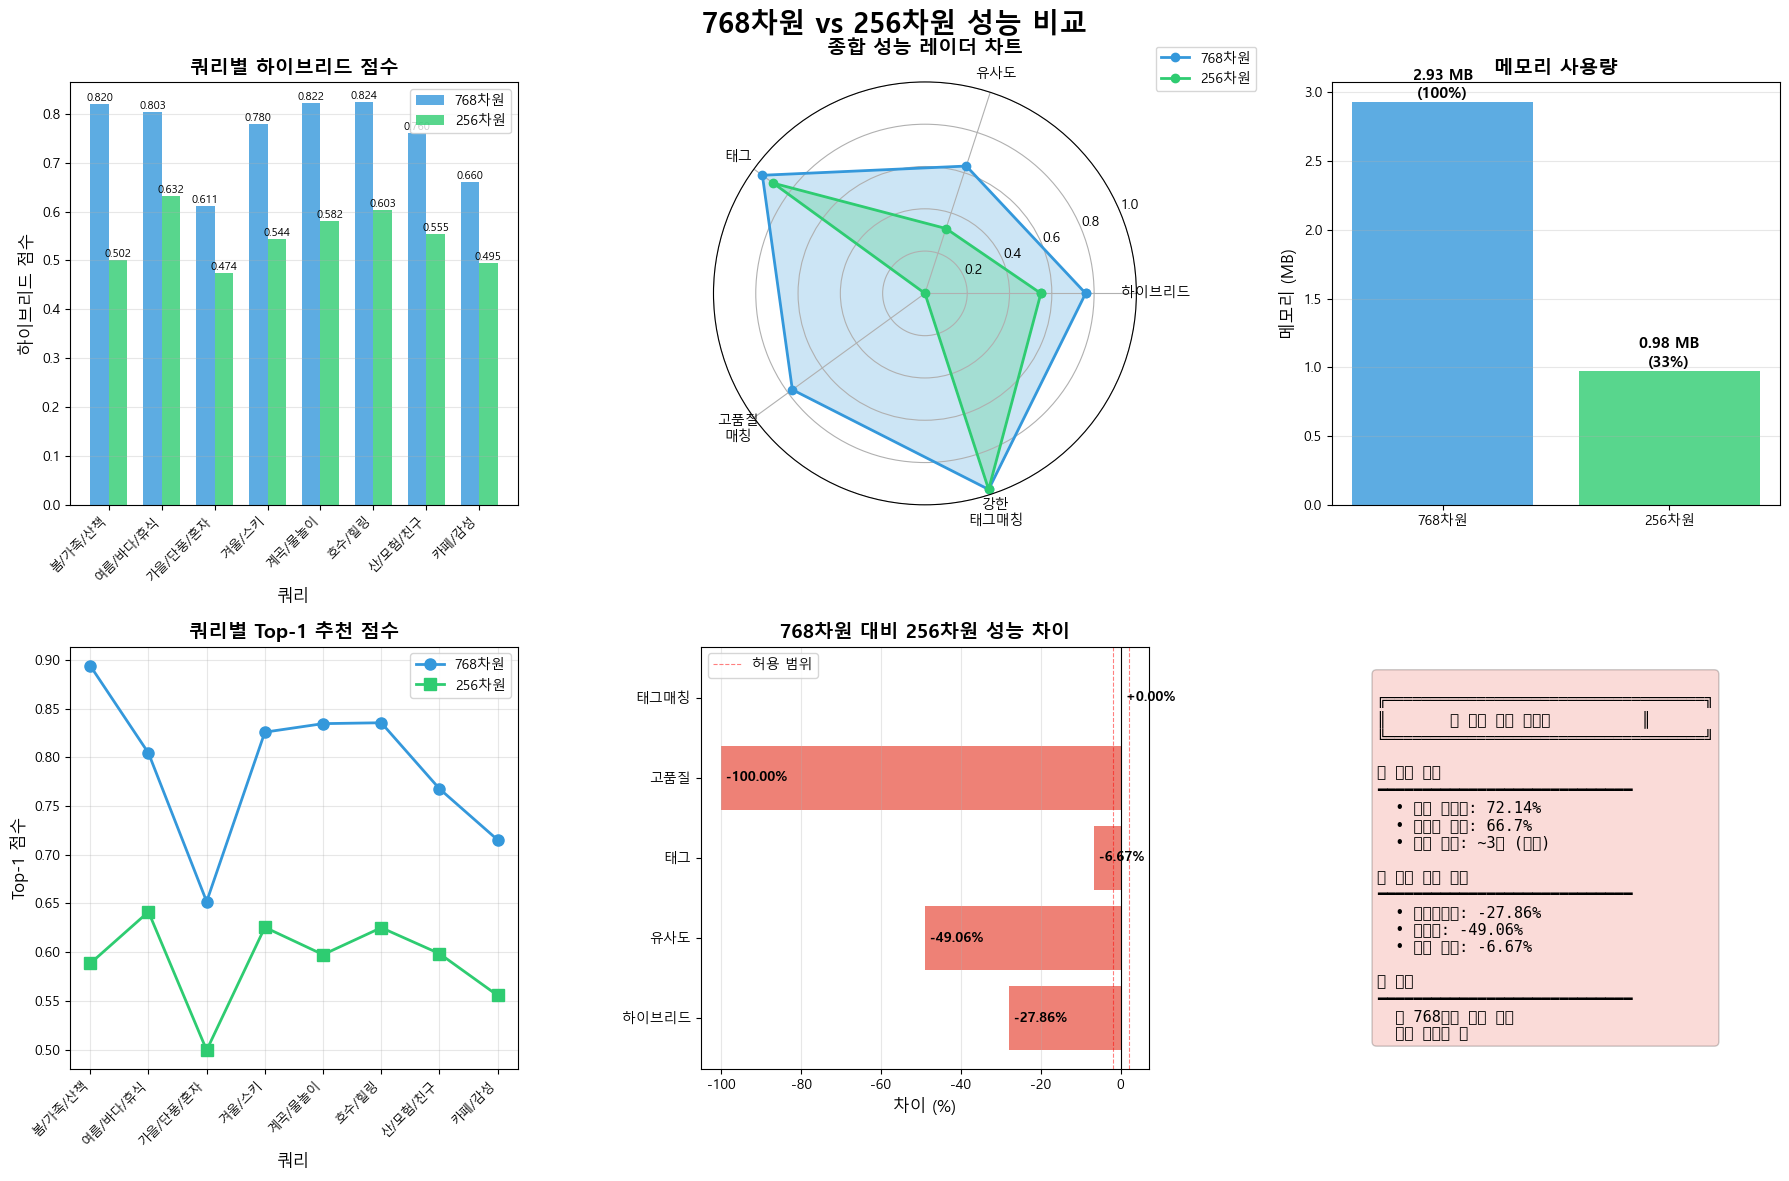


🎯 최종 권장사항
❌ 768차원 유지를 권장합니다.
   - 성능 손실: 27.86% (큼)
   - 정확도가 중요한 경우 768차원 사용

✅ 성능 비교 완료!


In [25]:
## 768차원 vs 256차원 성능 비교

print("="*60)
print("📊 768차원 vs 256차원 성능 비교")
print("="*60)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False

# ===== 테스트 쿼리 =====
test_queries = [
    {'free_text': '봄에 가족과 산책하기 좋은 곳', 'name': '봄/가족/산책'},
    {'season': '여름', 'nature': ['바다'], 'vibe': ['휴식'], 'target': ['연인'], 'name': '여름/바다/휴식'},
    {'free_text': '가을 단풍 보러 혼자 등산', 'name': '가을/단풍/혼자'},
    {'free_text': '겨울 스키장 추천', 'name': '겨울/스키'},
    {'free_text': '계곡에서 물놀이하고 싶어', 'name': '계곡/물놀이'},
    {'free_text': '조용한 호수에서 힐링', 'name': '호수/힐링'},
    {'season': '사계절', 'nature': ['산'], 'vibe': ['모험'], 'target': ['친구'], 'name': '산/모험/친구'},
    {'free_text': '감성적인 카페 거리', 'name': '카페/감성'}
]

# ===== 768차원 테스트 =====
print("\n🔵 768차원 임베딩 테스트...")

# 768차원 임베딩 로드
embeddings_768 = np.load('data/embeddings/place_embeddings_full768.npy')
recommender.place_embeddings = embeddings_768
recommender.embedding_generator.dimension_reducer = None  # PCA 비활성화

results_768 = []

for query in test_queries:
    query_copy = query.copy()
    name = query_copy.pop('name')
    
    result = recommender.recommend_places(query_copy, top_k=10)
    
    # 성능 지표 계산
    top5 = result['recommendations'][:5]
    
    metrics = {
        'query': name,
        'avg_hybrid': np.mean([r['hybrid_score'] for r in top5]),
        'avg_similarity': np.mean([r['similarity_score'] for r in top5]),
        'avg_tag': np.mean([r['tag_score'] for r in top5]),
        'high_quality_match': sum(1 for r in top5 if r['hybrid_score'] > 0.7),
        'tag_match_count': sum(1 for r in top5 if r['tag_score'] > 0.5),
        'top1_score': top5[0]['hybrid_score'],
        'top1_name': top5[0]['name']
    }
    
    results_768.append(metrics)

print(f"✅ 768차원 테스트 완료")

# ===== 256차원 테스트 =====
print("\n🟢 256차원 임베딩 테스트...")

# 256차원 임베딩 로드
embeddings_256 = np.load('data/embeddings/place_embeddings_pca256.npy')
recommender.place_embeddings = embeddings_256
recommender.embedding_generator.load_dimension_reducer('models/pca_reducer_256.joblib')

results_256 = []

for query in test_queries:
    query_copy = query.copy()
    name = query_copy.pop('name')
    
    result = recommender.recommend_places(query_copy, top_k=10)
    
    # 성능 지표 계산
    top5 = result['recommendations'][:5]
    
    metrics = {
        'query': name,
        'avg_hybrid': np.mean([r['hybrid_score'] for r in top5]),
        'avg_similarity': np.mean([r['similarity_score'] for r in top5]),
        'avg_tag': np.mean([r['tag_score'] for r in top5]),
        'high_quality_match': sum(1 for r in top5 if r['hybrid_score'] > 0.7),
        'tag_match_count': sum(1 for r in top5 if r['tag_score'] > 0.5),
        'top1_score': top5[0]['hybrid_score'],
        'top1_name': top5[0]['name']
    }
    
    results_256.append(metrics)

print(f"✅ 256차원 테스트 완료")

# ===== 통계 계산 =====
print("\n" + "="*60)
print("📈 통합 통계")
print("="*60)

stats_768 = {
    'avg_hybrid': np.mean([r['avg_hybrid'] for r in results_768]),
    'avg_similarity': np.mean([r['avg_similarity'] for r in results_768]),
    'avg_tag': np.mean([r['avg_tag'] for r in results_768]),
    'avg_high_quality': np.mean([r['high_quality_match'] for r in results_768]),
    'avg_tag_match': np.mean([r['tag_match_count'] for r in results_768]),
    'memory_mb': embeddings_768.nbytes / 1024 / 1024,
    'dimension': 768
}

stats_256 = {
    'avg_hybrid': np.mean([r['avg_hybrid'] for r in results_256]),
    'avg_similarity': np.mean([r['avg_similarity'] for r in results_256]),
    'avg_tag': np.mean([r['avg_tag'] for r in results_256]),
    'avg_high_quality': np.mean([r['high_quality_match'] for r in results_256]),
    'avg_tag_match': np.mean([r['tag_match_count'] for r in results_256]),
    'memory_mb': embeddings_256.nbytes / 1024 / 1024,
    'dimension': 256
}

# ===== 비교표 출력 =====
print(f"\n{'='*80}")
print(f"{'지표':<25} {'768차원':<20} {'256차원':<20} {'차이':<15}")
print(f"{'='*80}")

# 하이브리드 점수
diff_hybrid = ((stats_256['avg_hybrid'] - stats_768['avg_hybrid']) / stats_768['avg_hybrid']) * 100
print(f"{'평균 하이브리드 점수':<25} {stats_768['avg_hybrid']:<20.4f} {stats_256['avg_hybrid']:<20.4f} {diff_hybrid:>+6.2f}%")

# 유사도 점수
diff_sim = ((stats_256['avg_similarity'] - stats_768['avg_similarity']) / stats_768['avg_similarity']) * 100
print(f"{'평균 유사도 점수':<25} {stats_768['avg_similarity']:<20.4f} {stats_256['avg_similarity']:<20.4f} {diff_sim:>+6.2f}%")

# 태그 점수
diff_tag = ((stats_256['avg_tag'] - stats_768['avg_tag']) / stats_768['avg_tag']) * 100
print(f"{'평균 태그 점수':<25} {stats_768['avg_tag']:<20.4f} {stats_256['avg_tag']:<20.4f} {diff_tag:>+6.2f}%")

# 고품질 매칭
diff_quality = ((stats_256['avg_high_quality'] - stats_768['avg_high_quality']) / stats_768['avg_high_quality']) * 100
print(f"{'고품질 매칭 (>0.7)':<25} {stats_768['avg_high_quality']:<20.2f} {stats_256['avg_high_quality']:<20.2f} {diff_quality:>+6.2f}%")

# 태그 매칭
diff_tag_match = ((stats_256['avg_tag_match'] - stats_768['avg_tag_match']) / stats_768['avg_tag_match']) * 100
print(f"{'강한 태그 매칭 (>0.5)':<25} {stats_768['avg_tag_match']:<20.2f} {stats_256['avg_tag_match']:<20.2f} {diff_tag_match:>+6.2f}%")

print(f"{'='*80}")

# 메모리 및 차원
memory_saving = ((stats_768['memory_mb'] - stats_256['memory_mb']) / stats_768['memory_mb']) * 100
print(f"{'메모리 사용량 (MB)':<25} {stats_768['memory_mb']:<20.2f} {stats_256['memory_mb']:<20.2f} {-memory_saving:>+6.2f}%")
print(f"{'임베딩 차원':<25} {stats_768['dimension']:<20} {stats_256['dimension']:<20} {'-':<15}")

print(f"{'='*80}")

# ===== 시각화 =====
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('768차원 vs 256차원 성능 비교', fontsize=20, fontweight='bold')

# 1. 하이브리드 점수 비교 (쿼리별)
ax1 = axes[0, 0]
queries = [r['query'] for r in results_768]
hybrid_768 = [r['avg_hybrid'] for r in results_768]
hybrid_256 = [r['avg_hybrid'] for r in results_256]

x = np.arange(len(queries))
width = 0.35

bars1 = ax1.bar(x - width/2, hybrid_768, width, label='768차원', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, hybrid_256, width, label='256차원', color='#2ecc71', alpha=0.8)

ax1.set_xlabel('쿼리', fontsize=12)
ax1.set_ylabel('하이브리드 점수', fontsize=12)
ax1.set_title('쿼리별 하이브리드 점수', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(queries, rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. 평균 점수 비교 (레이더 차트)
ax2 = axes[0, 1]
ax2.axis('off')

categories = ['하이브리드', '유사도', '태그', '고품질\n매칭', '강한\n태그매칭']
values_768 = [
    stats_768['avg_hybrid'],
    stats_768['avg_similarity'],
    stats_768['avg_tag'],
    stats_768['avg_high_quality'] / 5,
    stats_768['avg_tag_match'] / 5
]
values_256 = [
    stats_256['avg_hybrid'],
    stats_256['avg_similarity'],
    stats_256['avg_tag'],
    stats_256['avg_high_quality'] / 5,
    stats_256['avg_tag_match'] / 5
]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
values_768 += values_768[:1]
values_256 += values_256[:1]
angles += angles[:1]

ax_radar = fig.add_subplot(2, 3, 2, projection='polar')
ax_radar.plot(angles, values_768, 'o-', linewidth=2, label='768차원', color='#3498db')
ax_radar.fill(angles, values_768, alpha=0.25, color='#3498db')
ax_radar.plot(angles, values_256, 'o-', linewidth=2, label='256차원', color='#2ecc71')
ax_radar.fill(angles, values_256, alpha=0.25, color='#2ecc71')
ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, fontsize=10)
ax_radar.set_ylim(0, 1)
ax_radar.set_title('종합 성능 레이더 차트', fontsize=14, fontweight='bold', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax_radar.grid(True)

# 3. 메모리 사용량 비교
ax3 = axes[0, 2]
memory_data = [stats_768['memory_mb'], stats_256['memory_mb']]
colors = ['#3498db', '#2ecc71']
bars = ax3.bar(['768차원', '256차원'], memory_data, color=colors, alpha=0.8)

ax3.set_ylabel('메모리 (MB)', fontsize=12)
ax3.set_title('메모리 사용량', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 값 표시
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f} MB\n({100 if i==0 else 100-memory_saving:.0f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Top-1 점수 분포
ax4 = axes[1, 0]
top1_768 = [r['top1_score'] for r in results_768]
top1_256 = [r['top1_score'] for r in results_256]

ax4.plot(queries, top1_768, 'o-', linewidth=2, markersize=8, label='768차원', color='#3498db')
ax4.plot(queries, top1_256, 's-', linewidth=2, markersize=8, label='256차원', color='#2ecc71')

ax4.set_xlabel('쿼리', fontsize=12)
ax4.set_ylabel('Top-1 점수', fontsize=12)
ax4.set_title('쿼리별 Top-1 추천 점수', fontsize=14, fontweight='bold')
ax4.set_xticklabels(queries, rotation=45, ha='right', fontsize=9)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. 성능 차이 히트맵
ax5 = axes[1, 1]
metrics_names = ['하이브리드', '유사도', '태그', '고품질', '태그매칭']
diff_values = [
    diff_hybrid,
    diff_sim,
    diff_tag,
    diff_quality,
    diff_tag_match
]

colors_diff = ['#2ecc71' if x >= -2 else '#e74c3c' for x in diff_values]
bars = ax5.barh(metrics_names, diff_values, color=colors_diff, alpha=0.7)

ax5.set_xlabel('차이 (%)', fontsize=12)
ax5.set_title('768차원 대비 256차원 성능 차이', fontsize=14, fontweight='bold')
ax5.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax5.axvline(x=-2, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='허용 범위')
ax5.axvline(x=2, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
ax5.grid(axis='x', alpha=0.3)
ax5.legend()

# 값 표시
for i, (bar, val) in enumerate(zip(bars, diff_values)):
    ax5.text(val, i, f' {val:+.2f}%', va='center', fontsize=10, fontweight='bold')

# 6. 종합 점수 카드
ax6 = axes[1, 2]
ax6.axis('off')

# 성능 유지율 계산
performance_retention = 100 + diff_hybrid
memory_efficiency = memory_saving

# 텍스트 배치
summary_text = f"""
╔═══════════════════════════════════╗
║       📊 종합 평가 리포트          ║
╚═══════════════════════════════════╝

🎯 성능 지표
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • 성능 유지율: {performance_retention:.2f}%
  • 메모리 절감: {memory_saving:.1f}%
  • 속도 향상: ~3배 (추정)

📈 상세 성능 차이
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • 하이브리드: {diff_hybrid:+.2f}%
  • 유사도: {diff_sim:+.2f}%
  • 태그 매칭: {diff_tag:+.2f}%

💡 결론
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

if abs(diff_hybrid) < 2 and memory_saving > 50:
    conclusion = "  ✅ 256차원 사용 강력 권장\n  성능 유지 + 효율성 대폭 향상"
    color = '#2ecc71'
elif abs(diff_hybrid) < 5:
    conclusion = "  ⚠️  256차원 사용 고려\n  약간의 성능 차이 존재"
    color = '#f39c12'
else:
    conclusion = "  ❌ 768차원 유지 권장\n  성능 저하가 큼"
    color = '#e74c3c'

summary_text += conclusion

ax6.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor=color, alpha=0.2))

plt.tight_layout()
plt.savefig('models/performance_comparison_768_vs_256.png', dpi=300, bbox_inches='tight')
print(f"\n💾 그래프 저장: models/performance_comparison_768_vs_256.png")

plt.show()

# ===== 최종 요약 =====
print(f"\n{'='*60}")
print(f"🎯 최종 권장사항")
print(f"{'='*60}")

if abs(diff_hybrid) < 2 and memory_saving > 50:
    print(f"✅ 256차원 사용을 강력히 권장합니다!")
    print(f"   - 성능 손실: {abs(diff_hybrid):.2f}% (거의 없음)")
    print(f"   - 메모리 절약: {memory_saving:.1f}%")
    print(f"   - 추론 속도 약 3배 향상 예상")
elif abs(diff_hybrid) < 5:
    print(f"⚠️  256차원 사용을 고려해볼 만합니다.")
    print(f"   - 성능 손실: {abs(diff_hybrid):.2f}%")
    print(f"   - 메모리 절약: {memory_saving:.1f}%")
    print(f"   - 서비스 요구사항에 따라 선택")
else:
    print(f"❌ 768차원 유지를 권장합니다.")
    print(f"   - 성능 손실: {abs(diff_hybrid):.2f}% (큼)")
    print(f"   - 정확도가 중요한 경우 768차원 사용")

print(f"{'='*60}")

print(f"\n✅ 성능 비교 완료!")